<a href="https://colab.research.google.com/github/MasoudHadi98/Algo_Trading/blob/edit1/algo_trading1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [1]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import numpy as np
import seaborn as sns
#import talib as ta
import bs4 as bs
import requests
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings("ignore")

**Import S&P500 Stocks price**

In [3]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,7,1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


**Preprocesesing Handel nulls**

In [4]:
#Preprocesesing Handel nulls
if data.isnull().values.any() :
    data.fillna(method='backfill',inplace=True)
    data.fillna(method='ffill',inplace=True)
    data.dropna(axis=1,inplace=True)
    print(data.isnull().sum().sum())

0


**Import SPY as S&P500 Index**

In [5]:
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,7,1)
spy = yf.download('SPY', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


**Feature extarction**

In [6]:
spy['Return'] = spy['Adj Close']/spy['Adj Close'].shift(1) - 1
spy['Next Price'] = spy['Adj Close'].shift(-1)
spy['Next Return'] = spy['Return'].shift(-1)
spy['Cumulative Return'] = (1 + spy['Return']).cumprod()
spy['Signal'] = spy['Next Return'].apply(lambda x : 1 if x>(0.005) else (-1 if x<-0.005 else 0 ))

take a look at chart

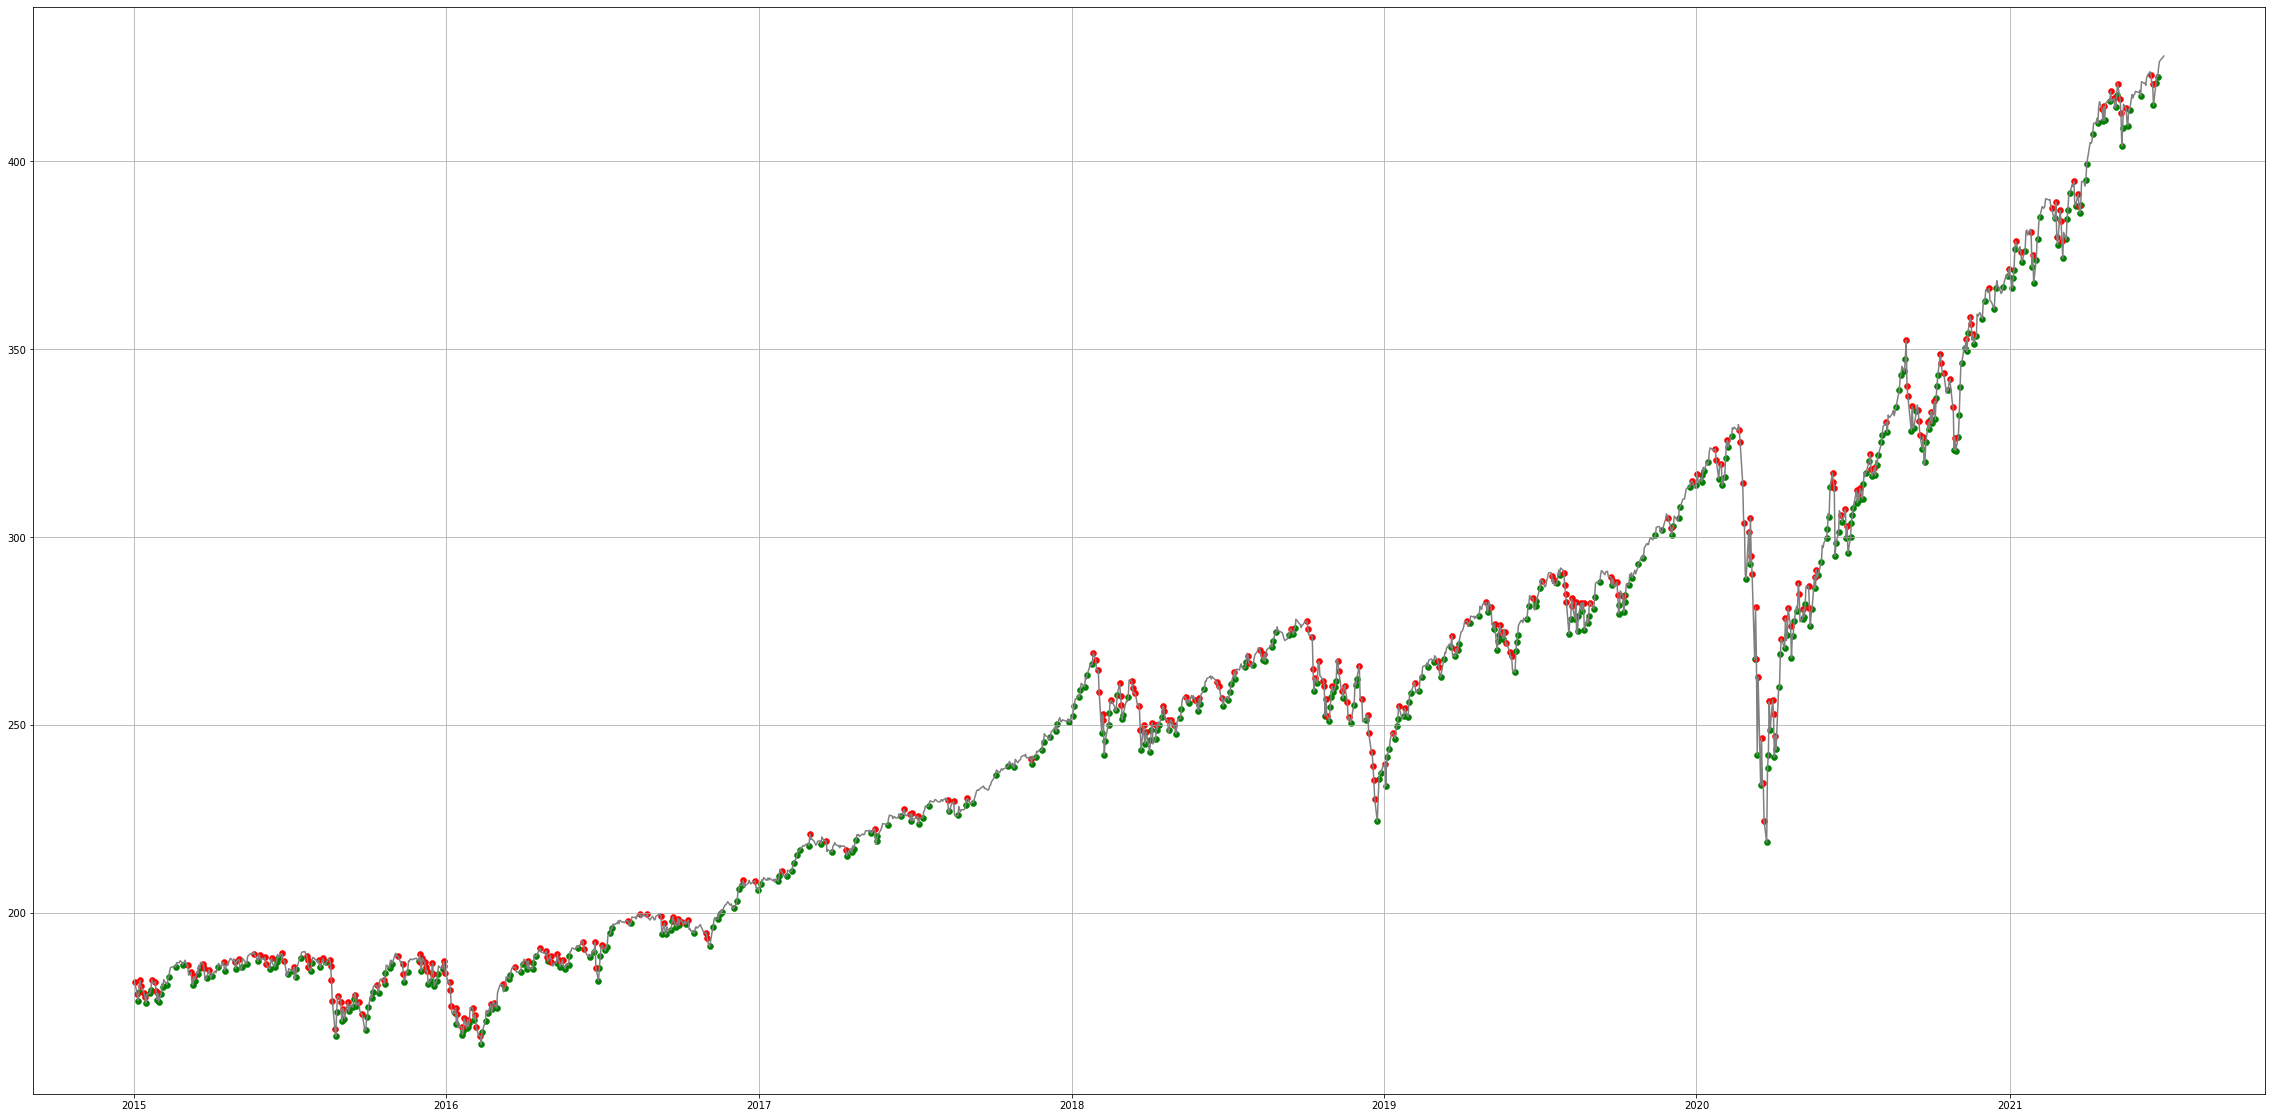

In [7]:
chart = pd.DataFrame()
chart['Price'] = spy['Adj Close']
chart['Signal'] = spy['Signal']

chart['Hold'] = chart['Price'].loc[chart['Signal']==0]
chart['Buy'] = chart['Price'].loc[chart['Signal']==1]
chart['Sell'] = chart['Price'].loc[chart['Signal']==-1]

plt.figure(figsize=(40,20))
plt.plot(chart['Price'],c='gray')
#plt.scatter(chart.index,chart['Hold'],c='gray',linewidths=0.5)
plt.scatter(chart.index,chart['Buy'],c='green',linewidths=0.5)
plt.scatter(chart.index,chart['Sell'],c='red',linewidths=0.5)
plt.grid()
plt.show()

**Feature Importance**

In [8]:
y = spy['Signal'][spy.index.isin(data['Adj Close'].index)]
X = data['Adj Close'][data['Adj Close'].index.isin(spy.index)]

x_train = X.loc[X.index < '2021-01-01']
y_train = y.loc[y.index < '2021-01-01']

from sklearn.ensemble import RandomForestClassifier
fi_forest = RandomForestClassifier(random_state=42)
fi_forest.fit(x_train, y_train)
FI = pd.DataFrame()

FI['Stock'] = data['Adj Close'].columns
FI['Importance'] = fi_forest.feature_importances_

FI = FI.sort_values('Importance',ascending=False)
FI = FI.reset_index()
VIP = FI['Stock'].loc[:100].values
print (FI['Stock'].loc[:100].values)

['IBM' 'PVH' 'XOM' 'BKR' 'MHK' 'UNM' 'FANG' 'LEG' 'WYNN' 'WAB' 'ENPH'
 'APA' 'HAL' 'HBI' 'OMC' 'SEE' 'BEN' 'PXD' 'ABC' 'VNO' 'IRM' 'VTR' 'KHC'
 'LNC' 'GILD' 'PBCT' 'DXC' 'KMI' 'KIM' 'L' 'COG' 'APD' 'WHR' 'NLSN' 'CAH'
 'NWL' 'FDX' 'VIAC' 'DISCA' 'REG' 'VFC' 'CL' 'TSLA' 'WY' 'LKQ' 'NOV' 'AIG'
 'SJM' 'CPB' 'AAL' 'HST' 'REGN' 'MET' 'TGT' 'MO' 'HSY' 'DISH' 'CAG' 'XRAY'
 'FMC' 'WMT' 'AKAM' 'DD' 'LUMN' 'OXY' 'VZ' 'ALK' 'JCI' 'TAP' 'RJF' 'DLTR'
 'FCX' 'BIIB' 'JNPR' 'RL' 'DISCK' 'NFLX' 'MDT' 'DG' 'WBA' 'ILMN' 'MCK'
 'HCA' 'BXP' 'EOG' 'CTSH' 'CERN' 'FRT' 'HES' 'STT' 'HPQ' 'CME' 'EMN' 'DIS'
 'SCHW' 'F' 'PFE' 'BA' 'CCI' 'IVZ' 'HPE']


**Change daily price to WMA5 & 
Make a new dataset with WMA5 , Vol , RSI**


In [20]:
"""
df_WMA5 = pd.DataFrame()
for stock in data['Adj Close'].columns :
    df_WMA5[stock] = ta.WMA(data['Adj Close'][stock],timeperiod = 5)
df_WMA5.dropna(inplace=True)

# Change daily price to RSI
df_RSI = pd.DataFrame()
for stock in data['Adj Close'].columns :
    df_RSI[stock] = ta.RSI(data['Adj Close'][stock],timeperiod = 14)
df_RSI.dropna(inplace=True)
"""

df_data = pd.DataFrame()
"""
df_data = pd.merge(df_WMA5[VIP]
                   ,data['Volume'][VIP]
                   ,right_index=True,left_index=True,suffixes=('_wma','_vol'))
df_data = pd.merge(df_data
                   ,df_RSI[VIP]
                   ,right_index=True,left_index=True,suffixes=('','_rsi'))
df_data = pd.merge(df_data
                   ,spy[['Adj Close','Volume']]
                   ,right_index=True,left_index=True,suffixes=('','_spy'))
df_data.dropna(axis=0,inplace=True)
"""
df_data = pd.merge(data['Adj Close'][VIP]
                   ,data['Volume'][VIP]
                   ,right_index=True,left_index=True,suffixes=('_wma','_vol'))

**Make a Function to measure performance**

In [10]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))
        """
        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        print('\n')
        """
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import normalize

test_date = '2020-01-01'
y = spy['Signal'][spy.index.isin(df_data.index)]
X = df_data[df_data.index.isin(spy.index)]

result = pd.DataFrame()
result['Real'] = spy['Signal'][spy.index.isin(df_data.index)]
result['MLP'] = 0
result['RF'] = 0
result['SVM'] = 0
result['KNN'] = 0

In [23]:
#Train Part

#x_train = normalize(X.loc[X.index < test_date],axis=1)
x_train = X.loc[X.index < test_date]
y_train = y.loc[y.index < test_date]
#x_test = normalize(X.loc[X.index > test_date],axis=1)
x_test = X.loc[X.index > test_date]
y_test = y.loc[y.index > test_date]

#mlp = MLPClassifier(hidden_layer_sizes = (500,),
#                    activation = 'tanh',
#                    solver ='adam',
#                    alpha = 0.001)
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
result['MLP'].loc[result.index < test_date] = mlp.predict(x_train)

#forest = RandomForestClassifier(max_depth =  5,
#                                max_features = 'log2',
#                                min_samples_leaf = 7,
#                                min_samples_split = 7,
#                                n_estimators = 10)
forest = RandomForestClassifier()
ada_rf = AdaBoostClassifier(base_estimator=forest, n_estimators=100, learning_rate=0.5)
ada_rf.fit(x_train, y_train.ravel())
#forest.fit(x_train, y_train)
result['RF'].loc[result.index < test_date] = ada_rf.predict(x_train)

svc = SVC()
svc.fit(x_train, y_train)
result['SVM'].loc[result.index< test_date] = svc.predict(x_train)

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
result['KNN'].loc[result.index< test_date] = knn.predict(x_train)

print('MLP :')
print_score(mlp, x_train, y_train, x_test, y_test, train=True)
print_score(mlp, x_train, y_train, x_test, y_test, train=False)
print('RF with Ada :')
print_score(ada_rf, x_train, y_train,x_test, y_test, train=True)
print_score(ada_rf, x_train, y_train,x_test, y_test, train=False)
print('SVC :')
print_score(svc, x_train, y_train,x_test, y_test, train=True)
print_score(svc, x_train, y_train,x_test, y_test, train=False)
print('KNN :')
print_score(knn, x_train, y_train,x_test, y_test, train=True)
print_score(knn, x_train, y_train,x_test, y_test, train=False)

MLP :
Train Result:

accuracy score: 0.8426

Classification Report: 
               precision    recall  f1-score   support

          -1       0.93      0.71      0.81       220
           0       0.80      0.99      0.88       737
           1       0.98      0.58      0.73       301

    accuracy                           0.84      1258
   macro avg       0.90      0.76      0.81      1258
weighted avg       0.87      0.84      0.83      1258


Confusion Matrix: 
 [[157  62   1]
 [  7 728   2]
 [  5 121 175]]

Test Result:

accuracy score: 0.3926

Classification Report: 
               precision    recall  f1-score   support

          -1       0.24      0.12      0.16        93
           0       0.42      0.51      0.46       146
           1       0.40      0.45      0.42       138

    accuracy                           0.39       377
   macro avg       0.36      0.36      0.35       377
weighted avg       0.37      0.39      0.37       377


Confusion Matrix: 
 [[11 39 43]
 [22

In [24]:
# Test Part

for i in y.loc[y.index >= test_date].index :

        x_train = X.loc[X.index < i]
        y_train = y.loc[y.index < i]
        x_test = X.loc[X.index == i]
        y_test = y.loc[y.index == i]

        #mlp = MLPClassifier(hidden_layer_sizes = (500,),
        #                    activation = 'tanh',
        #                    solver ='adam',
        #                    alpha = 0.001)
        mlp = MLPClassifier()
        mlp.fit(x_train, y_train)
        result['MLP'].loc[result.index == i] = mlp.predict(x_test)[0]
        
        #forest = RandomForestClassifier(max_depth =  5,
        #                                 max_features = 'log2',
        #                                 min_samples_leaf = 7,
        #                                 min_samples_split = 7,
        #                                 n_estimators = 10)
        forest = RandomForestClassifier()
        ada_rf = AdaBoostClassifier(base_estimator=forest, n_estimators=10, learning_rate=0.5)
        ada_rf.fit(x_train, y_train.ravel())
        #forest.fit(x_train, y_train)
        result['RF'].loc[result.index == i] = ada_rf.predict(x_test)[0]
        
        svc = SVC()
        svc.fit(x_train, y_train)
        result['SVM'].loc[result.index == i] = svc.predict(x_test)[0]
        
        knn = KNeighborsClassifier()
        knn.fit(x_train, y_train)
        result['KNN'].loc[result.index == i] = knn.predict(x_test)[0]      

In [ ]:
#GridSearch for RF
"""
from sklearn.model_selection import GridSearchCV

x_train =X.loc[X.index < test_date]
y_train = y.loc[y.index < test_date]

forest = RandomForestClassifier()

params_grid = {'n_estimators' : [10,20,50,100,200],
                'max_depth' : [5,10,15,20],
                'min_samples_split' : [2,5,7,10,20],
                'min_samples_leaf' : [1,3,5,7,10],
                'max_features' : ["auto", "sqrt", "log2"]}

grid_search = GridSearchCV(forest, params_grid,
                           n_jobs=-1, cv=5,
                           verbose=1, scoring='accuracy')

grid_search.fit(x_train, y_train)

print(grid_search.best_score_)

grid_search.best_estimator_.get_params()
"""

In [25]:
def CLF_Report (Model,y_test,y_model):
    print(Model)
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test,y_model)))
    print("Classification Report: \n {}\n".format(classification_report(y_test,y_model)))
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test,y_model)))
    
y_test = result['Real'].loc[y.index > test_date]
rf_test = result['RF'].loc[y.index > test_date]
mlp_test = result['MLP'].loc[y.index > test_date]
svc_test = result['SVM'].loc[y.index > test_date]
knn_test = result['KNN'].loc[y.index > test_date]

CLF_Report('RF',y_test, rf_test)
CLF_Report('MLP',y_test, mlp_test)
CLF_Report('SVM',y_test, svc_test)
CLF_Report('KNN',y_test, knn_test)

RF
accuracy score: 0.4615

Classification Report: 
               precision    recall  f1-score   support

          -1       0.27      0.17      0.21        93
           0       0.53      0.70      0.61       146
           1       0.44      0.41      0.42       138

    accuracy                           0.46       377
   macro avg       0.42      0.43      0.41       377
weighted avg       0.44      0.46      0.44       377


Confusion Matrix: 
 [[ 16  36  41]
 [ 14 102  30]
 [ 29  53  56]]

MLP
accuracy score: 0.3263

Classification Report: 
               precision    recall  f1-score   support

          -1       0.16      0.16      0.16        93
           0       0.40      0.36      0.38       146
           1       0.36      0.40      0.38       138

    accuracy                           0.33       377
   macro avg       0.31      0.31      0.31       377
weighted avg       0.33      0.33      0.33       377


Confusion Matrix: 
 [[15 38 40]
 [36 53 57]
 [41 42 55]]

SVM
ac

In [26]:
result['past Real'] = result['Real'].shift(1)
result.dropna(axis=0,inplace=True)

In [28]:
#Final model with MLP
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

#Train
y = result['Real']
X = result[['RF','MLP','SVM','past Real']]

x_train = X.loc[X.index < test_date]
y_train = y.loc[y.index < test_date]
x_test = X.loc[X.index > test_date]
y_test = y.loc[y.index > test_date]

result['Final'] = 0
result['Bag'] = 0

#knn = KNeighborsClassifier()
#knn.fit(x_train, y_train)
#result['Final'].loc[result.index < test_date] = knn.predict(x_train)

mlp_clf = MLPClassifier(hidden_layer_sizes = (50,),
                    activation = 'tanh',
                    solver ='adam',
                    alpha = 0.001)
mlp_clf.fit(x_train, y_train)
result['Final'].loc[result.index < test_date] = mlp_clf.predict(x_train)

#mlp_clf = MLPClassifier()
#mlp_clf.fit(x_train, y_train)
#result['Final'].loc[result.index < test_date] = mlp_clf.predict(x_train)

#forest_clf = RandomForestClassifier()
#ada_rf = AdaBoostClassifier(base_estimator=forest_clf, n_estimators=10, learning_rate=0.5)
#ada_rf.fit(x_train, y_train.ravel())
#forest_clf.fit(x_train, y_train.ravel())
#result['Final'].loc[result.index < test_date] = ada_rf.predict(x_train)
#result['Final'].loc[result.index < test_date] = forest_clf.predict(x_train)

clf = DecisionTreeClassifier(random_state=42)
bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                            bootstrap=True, n_jobs=-1,
                            random_state=42)
bag_clf.fit(x_train, y_train.ravel())
result['Bag'].loc[result.index < test_date] = bag_clf.predict(x_train)

y_train = result['Real'].loc[y.index < test_date]
final_train = result['Final'].loc[y.index < test_date]
CLF_Report('Final Train',y_train, final_train)

#Test
for i in y.loc[y.index >= test_date].index :
        x_train = X.loc[X.index < i].values
        y_train = y.loc[y.index < i]
        x_test = X.loc[X.index == i].values
        y_test = y.loc[y.index == i]

        #knn = KNeighborsClassifier()
        #knn.fit(x_train, y_train)
        #result['Final'].loc[result.index == i] = knn.predict(x_test)[0]
        
        mlp = MLPClassifier(hidden_layer_sizes = (50,),
                    activation = 'tanh',
                    solver ='adam',
                    alpha = 0.001)
        mlp_clf.fit(x_train, y_train)
        result['Final'].loc[result.index == i] = mlp_clf.predict(x_test)[0]
        
        #mlp = MLPClassifier()
        #mlp_clf.fit(x_train, y_train)
        #result['Final'].loc[result.index == i] = mlp_clf.predict(x_test)[0]
         
        #forest_clf = RandomForestClassifier()
        #ada_rf = AdaBoostClassifier(base_estimator=forest_clf, n_estimators=10, learning_rate=0.5)
        #ada_rf.fit(x_train, y_train.ravel())
        #forest_clf.fit(x_train, y_train.ravel())
        #result['Final'].loc[result.index == i] = ada_rf.predict(x_test)[0]
        #result['Final'].loc[result.index == i] = forest_clf.predict(x_test)[0]
        
        clf = DecisionTreeClassifier(random_state=42)
        bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                                    bootstrap=True, n_jobs=-1,
                                    random_state=42)
        bag_clf.fit(x_train, y_train.ravel())
        result['Bag'].loc[result.index == i] = bag_clf.predict(x_test)[0]


y_test = result['Real'].loc[y.index > test_date]
final_test = result['Final'].loc[y.index > test_date]
CLF_Report('Final Test :' , y_test , final_test)

Final Train
accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00       219
           0       1.00      1.00      1.00       737
           1       1.00      1.00      1.00       301

    accuracy                           1.00      1257
   macro avg       1.00      1.00      1.00      1257
weighted avg       1.00      1.00      1.00      1257


Confusion Matrix: 
 [[219   0   0]
 [  0 737   0]
 [  0   0 301]]

Final Test :
accuracy score: 0.4483

Classification Report: 
               precision    recall  f1-score   support

          -1       0.28      0.17      0.21        93
           0       0.52      0.68      0.59       146
           1       0.43      0.39      0.41       138

    accuracy                           0.45       377
   macro avg       0.41      0.41      0.40       377
weighted avg       0.42      0.45      0.43       377


Confusion Matrix: 
 [[16 35 42]
 [16 99 31]
 [

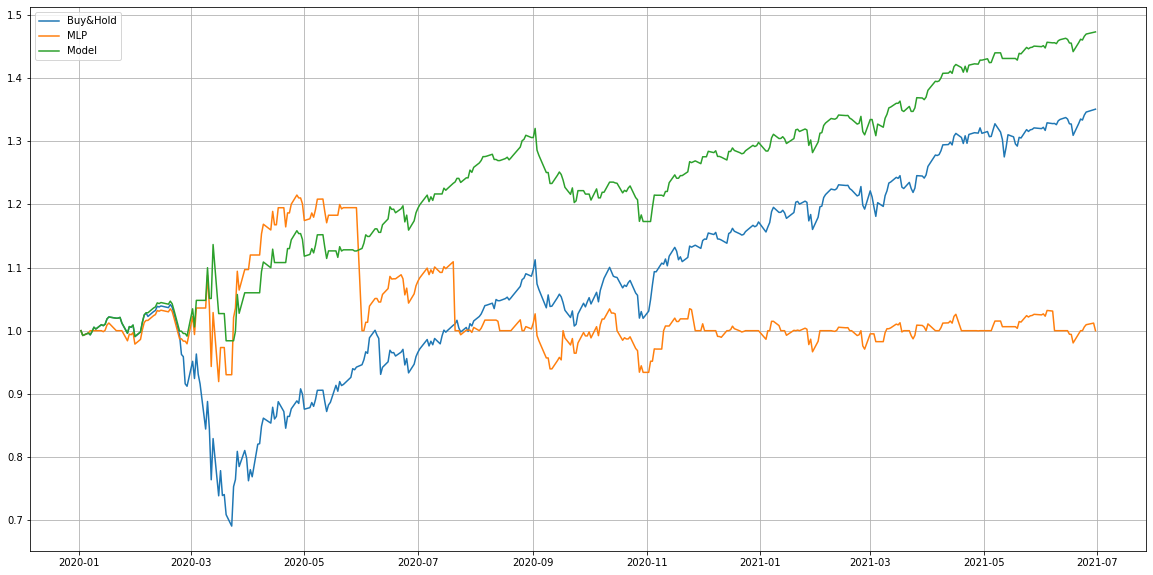

In [29]:
#x_test = normalize(X.loc[X.index > test_date],axis=0)
#y_test = y.loc[y.index > test_date]

Return = pd.DataFrame()
Return['Return'] = spy['Return'].loc[y_test.index]
Return['Return'][0] = 0
Return['Buy&Hold'] = (1 + Return['Return']).cumprod()
#result['Final'].loc[y_test.index][0] = 1

Return['model'] = 1
for idx,val in enumerate(y_test.index) :
    if idx==0:
        Return['model'].iloc[idx] = Return['Buy&Hold'].iloc[0]
    else:
        if result['Final'].loc[val] == 1 :
            Return['model'].loc[val] = Return['model'].iloc[idx-1] + Return['Return'].loc[val]
        if result['Final'].loc[val] == -1 :
            Return['model'].loc[val] = Return['model'].iloc[idx-1] 
        if result['Final'].loc[val] == 0 :
            for i in range(idx):
                if result['Final'].iloc[idx-i] == 1 :
                    Return['model'].loc[val] = Return['model'].iloc[idx-1] + Return['Return'].loc[val]
                    break
                if result['Final'].iloc[idx-i] == -1 :
                    Return['model'].loc[val] = Return['model'].iloc[idx-i]
                    break
                

Return['Bag'] = 1
for idx,val in enumerate(y_test.index) :
    if idx==0:
        Return['Bag'].iloc[idx] = 1
    else:
        if result['Bag'].loc[val] == 0 :
            Return['Bag'].loc[val] = Return['Bag'].iloc[idx-1] + Return['Return'].loc[val]
        if result['Bag'].loc[val] == 1 :
            Return['Bag'].loc[val] = Return['Bag'].iloc[idx-1] + Return['Return'].loc[val]
        if result['Bag'].loc[val] == -1 :
            Return['Bag'].loc[val] = Return['Bag'].iloc[idx-1] 
            
plt.figure(figsize=(20,10))
plt.plot(Return['Buy&Hold'],label='Buy&Hold')
plt.plot(Return['model'],label='MLP')
plt.plot(Return['Bag'],label='Model')

plt.legend()
plt.grid()
plt.show()

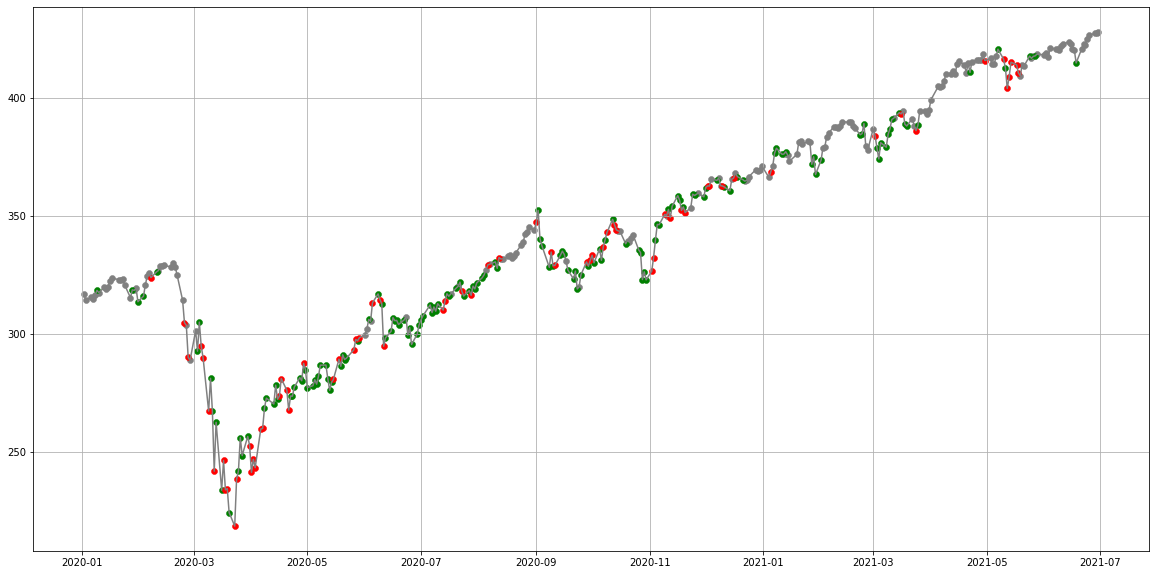

In [30]:
chart = pd.DataFrame()
chart['Price'] = spy['Adj Close'].loc[spy.index > test_date]
chart['Signal'] = result['Bag'].loc[result.index > test_date]

chart['Buy'] = chart['Price'].loc[chart['Signal']==1]
chart['Sell'] = chart['Price'].loc[chart['Signal']==-1]
chart['Hold'] = chart['Price'].loc[chart['Signal']==0]

plt.figure(figsize=(20,10))
plt.plot(chart['Price'],c='gray')
plt.scatter(chart.index,chart['Hold'],c='gray',linewidths=0.5)
plt.scatter(chart.index,chart['Buy'],c='green',linewidths=0.5)
plt.scatter(chart.index,chart['Sell'],c='red',linewidths=0.5)
plt.grid()
plt.show()